In [2]:
pip install pyspark

     |████████████████████████████████| 212.3MB 65kB/s 
     |████████████████████████████████| 204kB 46.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=b2ff048cad16d4ca7c7aa4c9c763fb014da4e770c11c6965650c53d563bba4fc
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [3]:
from pyspark.sql import *

In [87]:
# Create the Departments
de1 = Row(id='01', name='Computer Science')
de2 = Row(id='02', name='Software Engineering')

# Create the Student
Student = Row("Name", "MSSV","Salary")
student1 = Student('Nguyen Tran Quynh Nhu', '51800797',1000)
student4 = Student('Tran Quoc Sanh','51800809',2000)
student2 = Student('Pham Tommy','51800640',1500)
student3 = Student('Nguyen Thi Thanh Truc','51800944',1700)
student5 = Student('Tran Thanh Trung','51800646',1100)
student6 = Student('Pham Quoc Vuong','51800161',1300)
student7 = Student('Tran Thi Kim Tuyen','51800111',1400)
student8 = Student('Nguyen Hoang Long','51800576',1600)


de2_student1 = Row(department=de2, student=[student1,student4])
de1_student23 = Row(department = de1, student = [student2,student3])

print(de2)
print(student1)
print(de2_student1.student[0].MSSV)

Row(id='02', name='Software Engineering')
Row(Name='Nguyen Tran Quynh Nhu', MSSV='51800797', Salary=1000)
51800797


In [88]:
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
df = spark.createDataFrame([de2_student1,de1_student23])
display(df)

DataFrame[department: struct<id:string,name:string>, student: array<struct<Name:string,MSSV:string,Salary:bigint>>]

In [89]:
df2 = spark.createDataFrame([Row(department = de2, student = [student6,student7]),Row(department = de1, student = [student5,student8])])
display(df2)

DataFrame[department: struct<id:string,name:string>, student: array<struct<Name:string,MSSV:string,Salary:bigint>>]

In [90]:
unionDF = df.union(df2)
unionDF.show()
display(unionDF)

+--------------------+--------------------+
|          department|             student|
+--------------------+--------------------+
|{02, Software Eng...|[{Nguyen Tran Quy...|
|{01, Computer Sci...|[{Pham Tommy, 518...|
|{02, Software Eng...|[{Pham Quoc Vuong...|
|{01, Computer Sci...|[{Tran Thanh Trun...|
+--------------------+--------------------+



DataFrame[department: struct<id:string,name:string>, student: array<struct<Name:string,MSSV:string,Salary:bigint>>]

In [51]:
#Đọc data từ Parquet
# parquetDF = spark.read.parquet("/tmp/databricks-df-example.parquet")
# display(parquetDF)

In [92]:
from pyspark.sql.functions import explode

explodeDF = unionDF.select(explode("student").alias("st"))
flattenDF = explodeDF.selectExpr("st.name", "st.MSSV","st.Salary")

flattenDF.show()

+--------------------+--------+------+
|                name|    MSSV|Salary|
+--------------------+--------+------+
|Nguyen Tran Quynh...|51800797|  1000|
|      Tran Quoc Sanh|51800809|  2000|
|          Pham Tommy|51800640|  1500|
|Nguyen Thi Thanh ...|51800944|  1700|
|     Pham Quoc Vuong|51800161|  1300|
|  Tran Thi Kim Tuyen|51800111|  1400|
|    Tran Thanh Trung|51800646|  1100|
|   Nguyen Hoang Long|51800576|  1600|
+--------------------+--------+------+



In [93]:
#Dùng filter để trả về các hàng khớp với điều kiện
filterDF = flattenDF.filter(flattenDF.name == "Nguyen Tran Quynh Nhu").sort(flattenDF.MSSV)
filterDF.show()

+--------------------+--------+------+
|                name|    MSSV|Salary|
+--------------------+--------+------+
|Nguyen Tran Quynh...|51800797|  1000|
+--------------------+--------+------+



In [94]:
from pyspark.sql.functions import col, asc

filterDF = flattenDF.filter((col("name") == "Nguyen Tran Quynh Nhu") | (col("name") == "Tran Quoc Sanh")).sort(asc("MSSV"))
filterDF.show()

+--------------------+--------+------+
|                name|    MSSV|Salary|
+--------------------+--------+------+
|Nguyen Tran Quynh...|51800797|  1000|
|      Tran Quoc Sanh|51800809|  2000|
+--------------------+--------+------+



In [95]:
#where() tương đương với filter()
whereDF = flattenDF.where((col("name") == "Nguyen Tran Quynh Nhu") | (col("name") == "Tran Quoc Sanh")).sort(asc("MSSV"))
whereDF.show()

+--------------------+--------+------+
|                name|    MSSV|Salary|
+--------------------+--------+------+
|Nguyen Tran Quynh...|51800797|  1000|
|      Tran Quoc Sanh|51800809|  2000|
+--------------------+--------+------+



In [96]:
#Thay thế null bằng -- sử dụng DataFrame
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType

import pandas as pd
display(flattenDF)
data =[('Nguyen Thi Anh Thu',None,1450),[None,'51800044',990]]
newRow = spark.createDataFrame(data,["name","MSSV"])
flattenDF = flattenDF.union(newRow)
flattenDF.show()

nonNullDF = flattenDF.fillna("--")
nonNullDF.show()

DataFrame[name: string, MSSV: string, Salary: bigint]

+--------------------+--------+------+
|                name|    MSSV|Salary|
+--------------------+--------+------+
|Nguyen Tran Quynh...|51800797|  1000|
|      Tran Quoc Sanh|51800809|  2000|
|          Pham Tommy|51800640|  1500|
|Nguyen Thi Thanh ...|51800944|  1700|
|     Pham Quoc Vuong|51800161|  1300|
|  Tran Thi Kim Tuyen|51800111|  1400|
|    Tran Thanh Trung|51800646|  1100|
|   Nguyen Hoang Long|51800576|  1600|
|  Nguyen Thi Anh Thu|    null|  1450|
|                null|51800044|   990|
+--------------------+--------+------+

+--------------------+--------+------+
|                name|    MSSV|Salary|
+--------------------+--------+------+
|Nguyen Tran Quynh...|51800797|  1000|
|      Tran Quoc Sanh|51800809|  2000|
|          Pham Tommy|51800640|  1500|
|Nguyen Thi Thanh ...|51800944|  1700|
|     Pham Quoc Vuong|51800161|  1300|
|  Tran Thi Kim Tuyen|51800111|  1400|
|    Tran Thanh Trung|51800646|  1100|
|   Nguyen Hoang Long|51800576|  1600|
|  Nguyen Thi Anh Thu|  

In [97]:
#Trích xuất thông tin của student có name bị thiếu
filterNonNullDF = flattenDF.filter(col('name').isNull()).sort('MSSV')
filterNonNullDF.show()

+----+--------+------+
|name|    MSSV|Salary|
+----+--------+------+
|null|51800044|   990|
+----+--------+------+



In [98]:
from pyspark.sql.functions import countDistinct
#sử dụng agg() và countDistinct
countDistinctDF = nonNullDF.select("name","Salary").groupBy("name").agg(countDistinct("Salary").alias("distinct_MSSV"))
countDistinctDF.show()

+--------------------+-------------+
|                name|distinct_MSSV|
+--------------------+-------------+
|  Nguyen Thi Anh Thu|            1|
|      Tran Quoc Sanh|            1|
|    Tran Thanh Trung|            1|
|   Nguyen Hoang Long|            1|
|          Pham Tommy|            1|
|Nguyen Thi Thanh ...|            1|
|  Tran Thi Kim Tuyen|            1|
|Nguyen Tran Quynh...|            1|
|                  --|            1|
|     Pham Quoc Vuong|            1|
+--------------------+-------------+



In [99]:
#Cộng tất cả các Salary
MSSVSumDF = nonNullDF.agg({"Salary" : "sum"})
MSSVSumDF.show()

+-----------+
|sum(Salary)|
+-----------+
|      14040|
+-----------+



In [100]:
#In thống kê Salary
nonNullDF.describe("Salary").show()

+-------+-----------------+
|summary|           Salary|
+-------+-----------------+
|  count|               10|
|   mean|           1404.0|
| stddev|321.5310594984911|
|    min|              990|
|    max|             2000|
+-------+-----------------+



<Figure size 432x288 with 0 Axes>

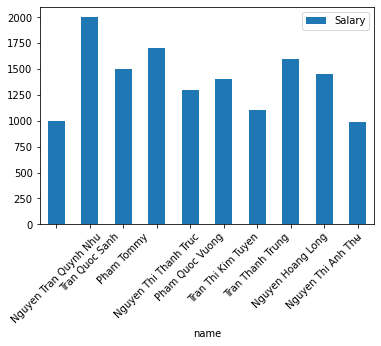

In [101]:
#Tích hợp pandas và Matlotlib

import pandas as pd
import matplotlib.pyplot as plt
plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='name', y='Salary', kind='bar', rot=45)
display()

In [106]:
from pyspark.sql import functions as F
from pyspark.sql.types import *


df = spark.read.format("csv").options(header='true', delimiter = ',').load("/content/sample_data/dataframe_sample.csv")
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- location: string (nullable = true)



In [109]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
add_n = udf(lambda x, y: x + y, IntegerType())

# Thêm một cột id_offset
df = df.withColumn('id_offset', add_n(F.lit(1000), df.id.cast(IntegerType())))
df.show()


+---+-------------------+-------------------+--------+---------+
| id|           end_date|         start_date|location|id_offset|
+---+-------------------+-------------------+--------+---------+
|  1|2015-10-14 00:00:00|2015-09-14 00:00:00|   CA-SF|     1001|
|  2|2015-10-15 01:00:20|2015-08-14 00:00:00|   CA-SD|     1002|
|  3|2015-10-16 02:30:00|2015-01-14 00:00:00|   NY-NY|     1003|
|  4|2015-10-17 03:00:20|2015-02-14 00:00:00|   NY-NY|     1004|
|  5|2015-10-18 04:30:00|2014-04-14 00:00:00|   CA-SD|     1005|
+---+-------------------+-------------------+--------+---------+



In [114]:
N = 90
last_n_days = udf(lambda x: x < N, BooleanType())
df = df.withColumn('date_diff', F.datediff(F.to_date(df.end_date), F.to_date(df.start_date)))
df_filtered = df.filter(last_n_days(df.date_diff))
df_filtered.show()

+---+-------------------+-------------------+--------+---------+---------+
| id|           end_date|         start_date|location|id_offset|date_diff|
+---+-------------------+-------------------+--------+---------+---------+
|  1|2015-10-14 00:00:00|2015-09-14 00:00:00|   CA-SF|     1001|       30|
|  2|2015-10-15 01:00:20|2015-08-14 00:00:00|   CA-SD|     1002|       62|
+---+-------------------+-------------------+--------+---------+---------+



In [116]:
# Provide the min, count, and avg and groupBy the location column. Diplay the results
agg_df = df.groupBy("location").agg(F.min("id"), F.count("id"), F.avg("date_diff"))
agg_df.show()

+--------+-------+---------+--------------+
|location|min(id)|count(id)|avg(date_diff)|
+--------+-------+---------+--------------+
|   NY-NY|      3|        2|         260.0|
|   CA-SF|      1|        1|          30.0|
|   CA-SD|      2|        2|         307.0|
+--------+-------+---------+--------------+

